<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/LSTM/LSTM_Nvidia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 144, done.
remote: Counting objects: 100% (144/144), done.
remote: Compressing objects: 100% (139/139), done.
remote: Total 144 (delta 69), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (144/144), 119.43 KiB | 5.43 MiB/s, done.
Resolving deltas: 100% (69/69), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Wed Jul 14 13:40:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'Nvidia'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'LSTM'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8MB 6.8MB/s 
     |████████████████████████████████| 143kB 38.6MB/s 
     |████████████████████████████████| 174kB 34.9MB/s 
     |████████████████████████████████| 102kB 9.5MB/s 
     |████████████████████████████████| 71kB 8.6MB/s 


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'dropout': {
            'values': [0.2, 0.3, 0.4]
        },
        'input_size': {
            'values': [25, 50, 100]
        },
        'hidden_size': {
            'values': [25, 50, 100]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop']
        },
        'activation': {
            'values': ['tanh']
        }
    }
}

In [13]:
# The sweep calls this function with each set of hyperparameters
def train():
    # Default values for hyper-parameters we're going to sweep over
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'dropout': 0.2,
        'input_size': 50,
        'hidden_size': 50,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config
    
    # Define the model architecture
    model = Sequential()

    # input layer
    model.add(LSTM(units=config.input_size, return_sequences=True, input_shape=(window_len, 1), activation=config.activation))
    model.add(Dropout(config.dropout))
    # second model layer with dropout
    model.add(LSTM(units=config.hidden_size, return_sequences=True, activation=config.activation))
    model.add(Dropout(config.dropout))
    # third model layer with dropout
    model.add(LSTM(units=config.hidden_size, return_sequences=True, activation=config.activation))
    model.add(Dropout(config.dropout))
    # fourth model layer with dropout
    model.add(LSTM(units=config.hidden_size, activation=config.activation))
    model.add(Dropout(config.dropout))
    # final layer with one output
    model.add(Dense(units=1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: 98zcxv6n
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_LSTM/sweeps/98zcxv6n


In [15]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: x2alidb1 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	hidden_size: 50
wandb: 	input_size: 25
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/100
16/16 [==============================] - 32s 180ms/step - loss: 0.0796 - mean_squared_error: 0.0796 - mean_absolute_error: 0.1979 - val_loss: 0.0161 - val_mean_squared_error: 0.0161 - val_mean_absolute_error: 0.0923
Epoch 2/100
16/16 [==============================] - 0s 19ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0634 - val_loss: 0.0212 - val_mean_squared_error: 0.0212 - val_mean_absolute_error: 0.1037
Epoch 3/100
16/16 [==============================] - 0s 21ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0471 - val_loss: 0.0159 - val_mean_squared_error: 0.0159 - val_mean_absolute_error: 0.1029
Epoch 4/100
16/16 [==============================] - 0s 20ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0362 - val_loss: 0.0199 - val_mean_squared_error: 0.0199 - val_mean_absolute_error: 0.0999
Epoch 5/100
16/16 [==============================] - 0s 20ms/step - loss: 0.0029 - mean_square

epoch,99
loss,0.00108
mean_squared_error,0.00108
mean_absolute_error,0.02195
val_loss,0.00657
val_mean_squared_error,0.00657
val_mean_absolute_error,0.05662
_runtime,76
_timestamp,1626270188
_step,99
best_val_loss,0.00543


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▃▃█▃▃▃▃▃▃▄▂▃▂▂▂▂▂▃▂▂▂▂▁▂▁▁▂▂▁▁▄▂▁▂▁▁▁▁▁
val_mean_squared_error,▃▃▃█▃▃▃▃▃▃▄▂▃▂▂▂▂▂▃▂▂▂▂▁▂▁▁▂▂▁▁▄▂▁▂▁▁▁▁▁
val_mean_absolute_error,▄▄▄█▄▄▄▄▃▃▄▃▃▃▂▃▂▂▄▃▂▃▂▂▂▂▂▂▂▁▂▅▂▁▃▁▁▁▂▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: ymm4km3g with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.4
wandb: 	epochs: 100
wandb: 	hidden_size: 25
wandb: 	input_size: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 10s 290ms/step - loss: 0.1190 - mean_squared_error: 0.1190 - mean_absolute_error: 0.2146 - val_loss: 0.1759 - val_mean_squared_error: 0.1759 - val_mean_absolute_error: 0.3858
Epoch 2/100
8/8 [==============================] - 0s 23ms/step - loss: 0.0406 - mean_squared_error: 0.0406 - mean_absolute_error: 0.1461 - val_loss: 0.0292 - val_mean_squared_error: 0.0292 - val_mean_absolute_error: 0.1313
Epoch 3/100
8/8 [==============================] - 0s 24ms/step - loss: 0.0264 - mean_squared_error: 0.0264 - mean_absolute_error: 0.1421 - val_loss: 0.0251 - val_mean_squared_error: 0.0251 - val_mean_absolute_error: 0.1344
Epoch 4/100
8/8 [==============================] - 0s 22ms/step - loss: 0.0139 - mean_squared_error: 0.0139 - mean_absolute_error: 0.0796 - val_loss: 0.0214 - val_mean_squared_error: 0.0214 - val_mean_absolute_error: 0.1109
Epoch 5/100
8/8 [==============================] - 0s 23ms/step - loss: 0.0088 - mean_squared_error: 0

epoch,15
loss,0.00627
mean_squared_error,0.00627
mean_absolute_error,0.04251
val_loss,0.02308
val_mean_squared_error,0.02308
val_mean_absolute_error,0.10951
_runtime,19
_timestamp,1626270218
_step,15
best_val_loss,0.02002


epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▅▂▁▂▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▃▃▃▅▅▅▅▅▅▆▆▆▆▆█
_timestamp,▁▃▃▃▅▅▅▅▅▅▆▆▆▆▆█
_step,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██


wandb: Agent Starting Run: i0j19yr4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	hidden_size: 50
wandb: 	input_size: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 11s 337ms/step - loss: 0.6037 - mean_squared_error: 0.6037 - mean_absolute_error: 0.4896 - val_loss: 0.0436 - val_mean_squared_error: 0.0436 - val_mean_absolute_error: 0.1526
Epoch 2/200
8/8 [==============================] - 0s 21ms/step - loss: 0.0249 - mean_squared_error: 0.0249 - mean_absolute_error: 0.1138 - val_loss: 0.0278 - val_mean_squared_error: 0.0278 - val_mean_absolute_error: 0.1182
Epoch 3/200
8/8 [==============================] - 0s 21ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0431 - val_loss: 0.3365 - val_mean_squared_error: 0.3365 - val_mean_absolute_error: 0.5394
Epoch 4/200
8/8 [==============================] - 0s 25ms/step - loss: 0.0446 - mean_squared_error: 0.0446 - mean_absolute_error: 0.1312 - val_loss: 0.1379 - val_mean_squared_error: 0.1379 - val_mean_absolute_error: 0.3357
Epoch 5/200
8/8 [==============================] - 0s 22ms/step - loss: 0.0185 - mean_squared_error: 0

epoch,53
loss,0.00476
mean_squared_error,0.00476
mean_absolute_error,0.05104
val_loss,0.02027
val_mean_squared_error,0.02027
val_mean_absolute_error,0.11235
_runtime,26
_timestamp,1626270252
_step,53
best_val_loss,0.00818


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▂▂▂▂▂▃▂▂▂▁▂▁▁▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▂▁█▃▁▂▁▃▁▁▂▂▂▁▂▂▁▁▁▁▁▁▃▁▁▁▁▁▂▂▂▂▁▁▁▁▁▁▂▁
val_mean_squared_error,▂▁█▃▁▂▁▃▁▁▂▂▂▁▂▂▁▁▁▁▁▁▃▁▁▁▁▁▂▂▂▂▁▁▁▁▁▁▂▁
val_mean_absolute_error,▂▂█▅▂▂▂▅▂▂▃▃▃▁▂▃▂▁▁▂▁▂▄▁▂▁▁▂▃▂▂▃▁▁▂▂▂▁▂▂
_runtime,▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█
_timestamp,▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: n92zimh9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	hidden_size: 100
wandb: 	input_size: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 11s 358ms/step - loss: 0.0796 - mean_squared_error: 0.0796 - mean_absolute_error: 0.1765 - val_loss: 0.0536 - val_mean_squared_error: 0.0536 - val_mean_absolute_error: 0.1857
Epoch 2/200
8/8 [==============================] - 0s 22ms/step - loss: 0.0096 - mean_squared_error: 0.0096 - mean_absolute_error: 0.0795 - val_loss: 0.0208 - val_mean_squared_error: 0.0208 - val_mean_absolute_error: 0.1228
Epoch 3/200
8/8 [==============================] - 0s 27ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0356 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - val_mean_absolute_error: 0.1092
Epoch 4/200
8/8 [==============================] - 0s 24ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0421 - val_loss: 0.0239 - val_mean_squared_error: 0.0239 - val_mean_absolute_error: 0.1112
Epoch 5/200
8/8 [==============================] - 0s 23ms/step - loss: 0.0024 - mean_squared_error: 0

epoch,14
loss,0.00165
mean_squared_error,0.00165
mean_absolute_error,0.02325
val_loss,0.02182
val_mean_squared_error,0.02182
val_mean_absolute_error,0.10614
_runtime,20
_timestamp,1626270279
_step,14
best_val_loss,0.02004


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▂▂▁▂▁▂▁▁▂▂▁▁▁
val_mean_squared_error,█▁▂▂▁▂▁▂▁▁▂▂▁▁▁
val_mean_absolute_error,█▃▁▂▁▂▁▂▁▁▁▁▁▁▁
_runtime,▁▁▁▃▃▃▃▃▆▆▆▆▆██
_timestamp,▁▁▁▃▃▃▃▃▆▆▆▆▆██
_step,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█


wandb: Agent Starting Run: k76gb5s3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	epochs: 200
wandb: 	hidden_size: 50
wandb: 	input_size: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
31/31 [==============================] - 12s 95ms/step - loss: 0.0360 - mean_squared_error: 0.0360 - mean_absolute_error: 0.1067 - val_loss: 0.0315 - val_mean_squared_error: 0.0315 - val_mean_absolute_error: 0.1589
Epoch 2/200
31/31 [==============================] - 1s 18ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0478 - val_loss: 0.0277 - val_mean_squared_error: 0.0277 - val_mean_absolute_error: 0.1195
Epoch 3/200
31/31 [==============================] - 1s 20ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0461 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - val_mean_absolute_error: 0.1284
Epoch 4/200
31/31 [==============================] - 1s 20ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0445 - val_loss: 0.0288 - val_mean_squared_error: 0.0288 - val_mean_absolute_error: 0.1211
Epoch 5/200
31/31 [==============================] - 1s 19ms/step - loss: 0.0052 - mean_squared

epoch,87
loss,0.00242
mean_squared_error,0.00242
mean_absolute_error,0.03211
val_loss,0.0192
val_mean_squared_error,0.0192
val_mean_absolute_error,0.10957
_runtime,72
_timestamp,1626270360
_step,87
best_val_loss,0.00942


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▂▂▂▂▂▂▁▁▁▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_loss,▆▄▄▃▃▅█▄▄▃▃▅▂▃▃▄▃▃▂▃▂▂▂▂▁▂▂▁▂▂▁▂▂▁▂▁▁▂▁▃
val_mean_squared_error,▆▄▄▃▃▅█▄▄▃▃▅▂▃▃▄▃▃▂▃▂▂▂▂▁▂▂▁▂▂▁▂▂▁▂▁▁▂▁▃
val_mean_absolute_error,█▆▄▄▄▆█▅▄▃▄▇▃▃▃▄▃▃▃▅▂▂▃▂▂▃▂▂▂▂▁▂▃▁▃▁▁▃▁▄
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qcoq1jox with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	hidden_size: 100
wandb: 	input_size: 25
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
31/31 [==============================] - 11s 79ms/step - loss: 0.0587 - mean_squared_error: 0.0587 - mean_absolute_error: 0.1456 - val_loss: 0.0219 - val_mean_squared_error: 0.0219 - val_mean_absolute_error: 0.1141
Epoch 2/100
31/31 [==============================] - 1s 19ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0502 - val_loss: 0.0326 - val_mean_squared_error: 0.0326 - val_mean_absolute_error: 0.1612
Epoch 3/100
31/31 [==============================] - 1s 19ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0530 - val_loss: 0.0259 - val_mean_squared_error: 0.0259 - val_mean_absolute_error: 0.1145
Epoch 4/100
31/31 [==============================] - 1s 18ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - mean_absolute_error: 0.0546 - val_loss: 0.0224 - val_mean_squared_error: 0.0224 - val_mean_absolute_error: 0.1061
Epoch 5/100
31/31 [==============================] - 1s 19ms/step - loss: 0.0043 - mean_squared

epoch,52
loss,0.00175
mean_squared_error,0.00175
mean_absolute_error,0.0278
val_loss,0.00996
val_mean_squared_error,0.00996
val_mean_absolute_error,0.06966
_runtime,50
_timestamp,1626270437
_step,52
best_val_loss,0.00827


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▃▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▂▄▃▂▂▄▂▂▂▂█▂▁▃▁▃▂▂▁▂▅▂▁▁▂▁▂▃▂▂▁▂▁▂▂▁▁▁▁▁
val_mean_squared_error,▂▄▃▂▂▄▂▂▂▂█▂▁▃▁▃▂▂▁▂▅▂▁▁▂▁▂▃▂▂▁▂▁▂▂▁▁▁▁▁
val_mean_absolute_error,▃▅▃▂▃▄▂▂▂▂█▃▂▄▂▃▃▂▂▃▆▃▂▂▂▁▃▃▃▃▁▂▁▃▃▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: v8vtbkgc with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	hidden_size: 100
wandb: 	input_size: 25
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
31/31 [==============================] - 10s 82ms/step - loss: 0.0317 - mean_squared_error: 0.0317 - mean_absolute_error: 0.1056 - val_loss: 0.0249 - val_mean_squared_error: 0.0249 - val_mean_absolute_error: 0.1145
Epoch 2/50
31/31 [==============================] - 1s 17ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0410 - val_loss: 0.0487 - val_mean_squared_error: 0.0487 - val_mean_absolute_error: 0.1780
Epoch 3/50
31/31 [==============================] - 1s 18ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0439 - val_loss: 0.0255 - val_mean_squared_error: 0.0255 - val_mean_absolute_error: 0.1139
Epoch 4/50
31/31 [==============================] - 1s 19ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0446 - val_loss: 0.0192 - val_mean_squared_error: 0.0192 - val_mean_absolute_error: 0.1155
Epoch 5/50
31/31 [==============================] - 1s 18ms/step - loss: 0.0039 - mean_squared_erro

epoch,19
loss,0.00214
mean_squared_error,0.00214
mean_absolute_error,0.02618
val_loss,0.03095
val_mean_squared_error,0.03095
val_mean_absolute_error,0.14213
_runtime,26
_timestamp,1626270472
_step,19
best_val_loss,0.01668


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▂▃▂▁▂▂▂▂▁▂▁▂▁▁▁▁▁▁
mean_squared_error,█▃▂▃▂▁▂▂▂▂▁▂▁▂▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁
val_loss,▂▅▂▁▁█▁▂▁▁▂▁▁▁▂▁▂▁▂▃
val_mean_squared_error,▂▅▂▁▁█▁▂▁▁▂▁▁▁▂▁▂▁▂▃
val_mean_absolute_error,▂▅▂▂▂█▂▂▁▂▃▁▂▁▃▁▃▁▃▃
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: 3aiuk2ib with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	hidden_size: 50
wandb: 	input_size: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
31/31 [==============================] - 11s 93ms/step - loss: 0.0608 - mean_squared_error: 0.0608 - mean_absolute_error: 0.1552 - val_loss: 0.0239 - val_mean_squared_error: 0.0239 - val_mean_absolute_error: 0.1132
Epoch 2/100
31/31 [==============================] - 1s 20ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0375 - val_loss: 0.0285 - val_mean_squared_error: 0.0285 - val_mean_absolute_error: 0.1330
Epoch 3/100
31/31 [==============================] - 1s 21ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0344 - val_loss: 0.0127 - val_mean_squared_error: 0.0127 - val_mean_absolute_error: 0.0836
Epoch 4/100
31/31 [==============================] - 1s 20ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0305 - val_loss: 0.0130 - val_mean_squared_error: 0.0130 - val_mean_absolute_error: 0.0827
Epoch 5/100
31/31 [==============================] - 1s 22ms/step - loss: 0.0018 - mean_squared

epoch,99
loss,0.00123
mean_squared_error,0.00123
mean_absolute_error,0.02445
val_loss,0.0029
val_mean_squared_error,0.0029
val_mean_absolute_error,0.0389
_runtime,83
_timestamp,1626270569
_step,99
best_val_loss,0.00272


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▃▂▂▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁
val_loss,█▄█▅▃▃▃▃▃▃▃▄▂▄▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▂▁▁▃▁▁▂▁▁▁▁
val_mean_squared_error,█▄█▅▃▃▃▃▃▃▃▄▂▄▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▂▁▁▃▁▁▂▁▁▁▁
val_mean_absolute_error,▇▅█▅▄▄▄▄▃▃▄▅▃▅▃▂▂▃▂▃▂▂▂▂▃▂▁▂▁▃▂▂▅▁▂▂▁▁▂▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: l6xcw8iz with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	hidden_size: 25
wandb: 	input_size: 25
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 12s 169ms/step - loss: 0.0341 - mean_squared_error: 0.0341 - mean_absolute_error: 0.1212 - val_loss: 0.0220 - val_mean_squared_error: 0.0220 - val_mean_absolute_error: 0.1257
Epoch 2/200
16/16 [==============================] - 0s 21ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0488 - val_loss: 0.0353 - val_mean_squared_error: 0.0353 - val_mean_absolute_error: 0.1682
Epoch 3/200
16/16 [==============================] - 0s 23ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0495 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - val_mean_absolute_error: 0.1312
Epoch 4/200
16/16 [==============================] - 0s 20ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0492 - val_loss: 0.0204 - val_mean_squared_error: 0.0204 - val_mean_absolute_error: 0.1177
Epoch 5/200
16/16 [==============================] - 0s 20ms/step - loss: 0.0058 - mean_square

epoch,124
loss,0.00176
mean_squared_error,0.00176
mean_absolute_error,0.02852
val_loss,0.01265
val_mean_squared_error,0.01265
val_mean_absolute_error,0.08297
_runtime,62
_timestamp,1626270652
_step,124
best_val_loss,0.00842


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▂▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▃▂▂▂▂▂▂▁▁▂▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▂▂█▂▂▂▄▂▄▄▃▂▂▂▂▁▁▁▁▁▂▁▃▁▁▁▂▁▁▁▂▂▁▁▁▂▁▁▁▁
val_mean_squared_error,▂▂█▂▂▂▄▂▄▄▃▂▂▂▂▁▁▁▁▁▂▁▃▁▁▁▂▁▁▁▂▂▁▁▁▂▁▁▁▁
val_mean_absolute_error,▃▃█▃▂▃▅▂▅▅▄▂▂▂▂▂▂▂▂▁▃▂▃▂▁▁▂▁▁▂▂▂▂▁▁▂▁▂▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: ubxi550e with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.4
wandb: 	epochs: 200
wandb: 	hidden_size: 25
wandb: 	input_size: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 11s 331ms/step - loss: 0.1223 - mean_squared_error: 0.1223 - mean_absolute_error: 0.2132 - val_loss: 0.1960 - val_mean_squared_error: 0.1960 - val_mean_absolute_error: 0.4070
Epoch 2/200
8/8 [==============================] - 0s 22ms/step - loss: 0.0435 - mean_squared_error: 0.0435 - mean_absolute_error: 0.1509 - val_loss: 0.0311 - val_mean_squared_error: 0.0311 - val_mean_absolute_error: 0.1259
Epoch 3/200
8/8 [==============================] - 0s 27ms/step - loss: 0.0266 - mean_squared_error: 0.0266 - mean_absolute_error: 0.1413 - val_loss: 0.0238 - val_mean_squared_error: 0.0238 - val_mean_absolute_error: 0.1335
Epoch 4/200
8/8 [==============================] - 0s 22ms/step - loss: 0.0111 - mean_squared_error: 0.0111 - mean_absolute_error: 0.0673 - val_loss: 0.0219 - val_mean_squared_error: 0.0219 - val_mean_absolute_error: 0.1081
Epoch 5/200
8/8 [==============================] - 0s 24ms/step - loss: 0.0098 - mean_squared_error: 0

epoch,59
loss,0.00523
mean_squared_error,0.00523
mean_absolute_error,0.04035
val_loss,0.02143
val_mean_squared_error,0.02143
val_mean_absolute_error,0.10354
_runtime,30
_timestamp,1626270692
_step,59
best_val_loss,0.01683


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 5kjtbu5s with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	hidden_size: 25
wandb: 	input_size: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 11s 184ms/step - loss: 0.0809 - mean_squared_error: 0.0809 - mean_absolute_error: 0.1734 - val_loss: 0.0281 - val_mean_squared_error: 0.0281 - val_mean_absolute_error: 0.1228
Epoch 2/200
16/16 [==============================] - 0s 25ms/step - loss: 0.0102 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0572 - val_loss: 0.0296 - val_mean_squared_error: 0.0296 - val_mean_absolute_error: 0.1237
Epoch 3/200
16/16 [==============================] - 0s 25ms/step - loss: 0.0119 - mean_squared_error: 0.0119 - mean_absolute_error: 0.0611 - val_loss: 0.0421 - val_mean_squared_error: 0.0421 - val_mean_absolute_error: 0.1527
Epoch 4/200
16/16 [==============================] - 0s 23ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0485 - val_loss: 0.0433 - val_mean_squared_error: 0.0433 - val_mean_absolute_error: 0.1573
Epoch 5/200
16/16 [==============================] - 0s 20ms/step - loss: 0.0073 - mean_square

epoch,27
loss,0.0045
mean_squared_error,0.0045
mean_absolute_error,0.03781
val_loss,0.02769
val_mean_squared_error,0.02769
val_mean_absolute_error,0.12335
_runtime,27
_timestamp,1626270728
_step,27
best_val_loss,0.01817


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▄▇▇▄▄▂▁▁▅▆▁▂▁▂▁▆▁▅█▅▄▁▁▁▃▂▃
val_mean_squared_error,▃▄▇▇▄▄▂▁▁▅▆▁▂▁▂▁▆▁▅█▅▄▁▁▁▃▂▃
val_mean_absolute_error,▃▃▆▆▃▃▃▂▂▄▅▃▂▃▄▂▆▁▅█▅▄▃▁▁▃▁▃
_runtime,▁▁▂▂▂▂▂▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇███
_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██


wandb: Agent Starting Run: u70t4jx2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	hidden_size: 25
wandb: 	input_size: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
31/31 [==============================] - 13s 99ms/step - loss: 0.0450 - mean_squared_error: 0.0450 - mean_absolute_error: 0.1203 - val_loss: 0.0259 - val_mean_squared_error: 0.0259 - val_mean_absolute_error: 0.1142
Epoch 2/50
31/31 [==============================] - 1s 25ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0541 - val_loss: 0.0259 - val_mean_squared_error: 0.0259 - val_mean_absolute_error: 0.1418
Epoch 3/50
31/31 [==============================] - 1s 25ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0500 - val_loss: 0.0177 - val_mean_squared_error: 0.0177 - val_mean_absolute_error: 0.0991
Epoch 4/50
31/31 [==============================] - 1s 25ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - mean_absolute_error: 0.0599 - val_loss: 0.0174 - val_mean_squared_error: 0.0174 - val_mean_absolute_error: 0.1074
Epoch 5/50
31/31 [==============================] - 1s 26ms/step - loss: 0.0066 - mean_squared_erro

epoch,49
loss,0.00285
mean_squared_error,0.00285
mean_absolute_error,0.03689
val_loss,0.01246
val_mean_squared_error,0.01246
val_mean_absolute_error,0.08709
_runtime,60
_timestamp,1626270805
_step,49
best_val_loss,0.00684


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▃▂▂▂▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▃▂▂▂▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▄▃▃▃▂▂▂▂▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▂▁▁▁
val_loss,▃▃▂▂▆▂▅▄▂▃▄▂▃▂█▂▂▁▂▄▂▃▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▂▂
val_mean_squared_error,▃▃▂▂▆▂▅▄▂▃▄▂▃▂█▂▂▁▂▄▂▃▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▂▂
val_mean_absolute_error,▃▄▃▃▆▂▆▄▂▄▅▃▄▂█▂▂▂▂▄▂▄▂▁▁▁▁▂▂▂▁▁▁▂▁▂▂▁▂▂
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 5xjo42rp with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	hidden_size: 50
wandb: 	input_size: 25
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
31/31 [==============================] - 12s 91ms/step - loss: 0.0332 - mean_squared_error: 0.0332 - mean_absolute_error: 0.1068 - val_loss: 0.0514 - val_mean_squared_error: 0.0514 - val_mean_absolute_error: 0.1862
Epoch 2/100
31/31 [==============================] - 1s 18ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0492 - val_loss: 0.0212 - val_mean_squared_error: 0.0212 - val_mean_absolute_error: 0.1069
Epoch 3/100
31/31 [==============================] - 1s 20ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0402 - val_loss: 0.0184 - val_mean_squared_error: 0.0184 - val_mean_absolute_error: 0.1056
Epoch 4/100
31/31 [==============================] - 1s 18ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0376 - val_loss: 0.0213 - val_mean_squared_error: 0.0213 - val_mean_absolute_error: 0.1046
Epoch 5/100
31/31 [==============================] - 1s 19ms/step - loss: 0.0041 - mean_squared

epoch,55
loss,0.00166
mean_squared_error,0.00166
mean_absolute_error,0.02721
val_loss,0.00853
val_mean_squared_error,0.00853
val_mean_absolute_error,0.06463
_runtime,53
_timestamp,1626270867
_step,55
best_val_loss,0.00791


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▄▃▃▃▃▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▃▃▃▅▄▂▂▂▃▂▃▃▂▂▂▂▂▂▂▂▂▃▁▁▂▁▄▁▁▁▂▂▂▁▂▂▁
val_mean_squared_error,█▃▃▃▃▃▅▄▂▂▂▃▂▃▃▂▂▂▂▂▂▂▂▂▃▁▁▂▁▄▁▁▁▂▂▂▁▂▂▁
val_mean_absolute_error,█▃▃▃▅▃▅▆▃▃▂▄▂▄▄▂▃▃▂▂▃▂▂▂▄▁▂▂▂▆▁▁▁▃▂▂▁▃▂▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 2e5kz028 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	hidden_size: 100
wandb: 	input_size: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
31/31 [==============================] - 11s 93ms/step - loss: 0.0550 - mean_squared_error: 0.0550 - mean_absolute_error: 0.1348 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - val_mean_absolute_error: 0.1081
Epoch 2/200
31/31 [==============================] - 1s 22ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0302 - val_loss: 0.0221 - val_mean_squared_error: 0.0221 - val_mean_absolute_error: 0.1067
Epoch 3/200
31/31 [==============================] - 1s 21ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0283 - val_loss: 0.0195 - val_mean_squared_error: 0.0195 - val_mean_absolute_error: 0.1022
Epoch 4/200
31/31 [==============================] - 1s 21ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0286 - val_loss: 0.0221 - val_mean_squared_error: 0.0221 - val_mean_absolute_error: 0.1058
Epoch 5/200
31/31 [==============================] - 1s 22ms/step - loss: 0.0027 - mean_squared

epoch,154
loss,0.00116
mean_squared_error,0.00116
mean_absolute_error,0.02207
val_loss,0.00688
val_mean_squared_error,0.00688
val_mean_absolute_error,0.05992
_runtime,125
_timestamp,1626271001
_step,154
best_val_loss,0.00525


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▅▅▄▄▇▂▄▅▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▂▂▁▁▁▁▁▁
mean_squared_error,█▆▅▅▄▄▇▂▄▅▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▂▂▁▁▁▁▁▁
mean_absolute_error,█▆▅▆▃▄▇▂▄▅▃▃▃▄▂▃▂▃▃▂▂▂▂▂▂▂▁▂▃▂▁▁▃▃▂▁▂▁▁▁
val_loss,██▇▇▅▅▅▄▄▄▄▃▃▄▃▃▇▃▂▂▂▂▂▄▂▂▃▂▂▂▁▁▁▁▁▁▁▂▁▁
val_mean_squared_error,██▇▇▅▅▅▄▄▄▄▃▃▄▃▃▇▃▂▂▂▂▂▄▂▂▃▂▂▂▁▁▁▁▁▁▁▂▁▁
val_mean_absolute_error,██▇▇▇▆▅▅▅▅▄▅▄▅▄▄█▄▃▃▃▃▃▅▂▃▄▃▂▂▂▂▂▂▂▁▂▂▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 2zlt6frt with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	hidden_size: 100
wandb: 	input_size: 25
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 12s 313ms/step - loss: 0.1043 - mean_squared_error: 0.1043 - mean_absolute_error: 0.1962 - val_loss: 0.0349 - val_mean_squared_error: 0.0349 - val_mean_absolute_error: 0.1341
Epoch 2/100
8/8 [==============================] - 0s 27ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0716 - val_loss: 0.0246 - val_mean_squared_error: 0.0246 - val_mean_absolute_error: 0.1156
Epoch 3/100
8/8 [==============================] - 0s 34ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0359 - val_loss: 0.0238 - val_mean_squared_error: 0.0238 - val_mean_absolute_error: 0.1354
Epoch 4/100
8/8 [==============================] - 0s 31ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0329 - val_loss: 0.0202 - val_mean_squared_error: 0.0202 - val_mean_absolute_error: 0.1133
Epoch 5/100
8/8 [==============================] - 0s 29ms/step - loss: 0.0032 - mean_squared_error: 0

epoch,24
loss,0.00299
mean_squared_error,0.00299
mean_absolute_error,0.03084
val_loss,0.03246
val_mean_squared_error,0.03246
val_mean_absolute_error,0.13502
_runtime,24
_timestamp,1626271035
_step,24
best_val_loss,0.01928


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
val_loss,▅▂▂▁▁▂▁▁▄▃▁▄▆▃▁▃▁▄▂██▁▃▄▅
val_mean_squared_error,▅▂▂▁▁▂▁▁▄▃▁▄▆▃▁▃▁▄▂██▁▃▄▅
val_mean_absolute_error,▄▂▄▂▂▂▂▂▃▂▂▃▆▂▂▂▁▃▂██▁▂▃▄
_runtime,▁▁▂▂▂▃▃▃▃▅▅▅▅▆▆▆▆▇▇▇▇████
_timestamp,▁▁▂▂▂▃▃▃▃▅▅▅▅▆▆▆▆▇▇▇▇████
_step,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: Agent Starting Run: gtfm02ek with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 50
wandb: 	hidden_size: 100
wandb: 	input_size: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 11s 161ms/step - loss: 0.0714 - mean_squared_error: 0.0714 - mean_absolute_error: 0.1648 - val_loss: 0.0182 - val_mean_squared_error: 0.0182 - val_mean_absolute_error: 0.1034
Epoch 2/50
16/16 [==============================] - 0s 23ms/step - loss: 0.0099 - mean_squared_error: 0.0099 - mean_absolute_error: 0.0528 - val_loss: 0.0426 - val_mean_squared_error: 0.0426 - val_mean_absolute_error: 0.1633
Epoch 3/50
16/16 [==============================] - 0s 24ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0498 - val_loss: 0.0266 - val_mean_squared_error: 0.0266 - val_mean_absolute_error: 0.1177
Epoch 4/50
16/16 [==============================] - 0s 23ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0431 - val_loss: 0.0198 - val_mean_squared_error: 0.0198 - val_mean_absolute_error: 0.1218
Epoch 5/50
16/16 [==============================] - 0s 23ms/step - loss: 0.0088 - mean_squared_err

epoch,15
loss,0.00503
mean_squared_error,0.00503
mean_absolute_error,0.04407
val_loss,0.01714
val_mean_squared_error,0.01714
val_mean_absolute_error,0.09259
_runtime,23
_timestamp,1626271080
_step,15
best_val_loss,0.01705


epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
loss,█▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▂▂▂▂▂▁▁▁▂▁▁▁
val_loss,▁▃▂▁▆▁▁█▂▂▁▁▃▂▁▁
val_mean_squared_error,▁▃▂▁▆▁▁█▂▂▁▁▃▂▁▁
val_mean_absolute_error,▁▃▂▂▆▁▁█▄▂▂▂▃▃▂▁
_runtime,▁▂▂▂▃▃▅▅▅▆▆▆▇▇██
_timestamp,▁▂▂▂▃▃▅▅▅▆▆▆▇▇██
_step,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██


wandb: Agent Starting Run: wrxzz6xl with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	hidden_size: 100
wandb: 	input_size: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
31/31 [==============================] - 12s 94ms/step - loss: 0.0621 - mean_squared_error: 0.0621 - mean_absolute_error: 0.1364 - val_loss: 0.0212 - val_mean_squared_error: 0.0212 - val_mean_absolute_error: 0.1227
Epoch 2/100
31/31 [==============================] - 1s 27ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0330 - val_loss: 0.0245 - val_mean_squared_error: 0.0245 - val_mean_absolute_error: 0.1134
Epoch 3/100
31/31 [==============================] - 1s 25ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0309 - val_loss: 0.0215 - val_mean_squared_error: 0.0215 - val_mean_absolute_error: 0.1094
Epoch 4/100
31/31 [==============================] - 1s 24ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0334 - val_loss: 0.0319 - val_mean_squared_error: 0.0319 - val_mean_absolute_error: 0.1307
Epoch 5/100
31/31 [==============================] - 1s 28ms/step - loss: 0.0028 - mean_squared

epoch,99
loss,0.00116
mean_squared_error,0.00116
mean_absolute_error,0.02149
val_loss,0.01026
val_mean_squared_error,0.01026
val_mean_absolute_error,0.07512
_runtime,101
_timestamp,1626271201
_step,99
best_val_loss,0.00713


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▃▃▂▂▂▂▂▂▂▂▁▂▂▂▂▁▂▂▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇▇█▅▇▅▄▇▅▄▄▃▄▃█▃▃▂▄▂▃▃▂▃▂▂▂▃▂▂▂▂▂▁▁▁▃▁▂▂
val_mean_squared_error,▇▇█▅▇▅▄▇▅▄▄▃▄▃█▃▃▂▄▂▃▃▂▃▂▂▂▃▂▂▂▂▂▁▁▁▃▁▂▂
val_mean_absolute_error,█▆▇▆▆▅▅▇▅▄▅▄▆▃█▃▃▃▆▂▃▃▂▂▂▂▂▃▂▁▃▂▂▁▂▁▄▁▂▂
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: w2zt9mb5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	epochs: 50
wandb: 	hidden_size: 25
wandb: 	input_size: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
31/31 [==============================] - 10s 86ms/step - loss: 0.1722 - mean_squared_error: 0.1722 - mean_absolute_error: 0.2396 - val_loss: 0.0724 - val_mean_squared_error: 0.0724 - val_mean_absolute_error: 0.2323
Epoch 2/50
31/31 [==============================] - 1s 21ms/step - loss: 0.0182 - mean_squared_error: 0.0182 - mean_absolute_error: 0.0891 - val_loss: 0.1186 - val_mean_squared_error: 0.1186 - val_mean_absolute_error: 0.3179
Epoch 3/50
31/31 [==============================] - 1s 20ms/step - loss: 0.0144 - mean_squared_error: 0.0144 - mean_absolute_error: 0.0835 - val_loss: 0.0191 - val_mean_squared_error: 0.0191 - val_mean_absolute_error: 0.1006
Epoch 4/50
31/31 [==============================] - 1s 21ms/step - loss: 0.0134 - mean_squared_error: 0.0134 - mean_absolute_error: 0.0827 - val_loss: 0.1384 - val_mean_squared_error: 0.1384 - val_mean_absolute_error: 0.3446
Epoch 5/50
31/31 [==============================] - 1s 21ms/step - loss: 0.0148 - mean_squared_erro

epoch,20
loss,0.00614
mean_squared_error,0.00614
mean_absolute_error,0.05347
val_loss,0.02608
val_mean_squared_error,0.02608
val_mean_absolute_error,0.14489
_runtime,30
_timestamp,1626271297
_step,20
best_val_loss,0.00796


epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
loss,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_loss,▄▇▂█▁▂▂▁▁▁▁▁▁▁▁▁▁▁▂▆▂
val_mean_squared_error,▄▇▂█▁▂▂▁▁▁▁▁▁▁▁▁▁▁▂▆▂
val_mean_absolute_error,▅▇▂█▂▃▂▁▁▁▁▁▁▁▂▂▁▁▃▆▃
_runtime,▁▁▂▃▃▃▃▃▄▅▅▅▅▅▆▇▇▇▇▇█
_timestamp,▁▁▂▃▃▃▃▃▄▅▅▅▅▅▆▇▇▇▇▇█
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: hs0t4m35 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 200
wandb: 	hidden_size: 100
wandb: 	input_size: 25
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 11s 192ms/step - loss: 0.0531 - mean_squared_error: 0.0531 - mean_absolute_error: 0.1469 - val_loss: 0.0990 - val_mean_squared_error: 0.0990 - val_mean_absolute_error: 0.2851
Epoch 2/200
16/16 [==============================] - 0s 23ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - mean_absolute_error: 0.0698 - val_loss: 0.0354 - val_mean_squared_error: 0.0354 - val_mean_absolute_error: 0.1415
Epoch 3/200
16/16 [==============================] - 0s 24ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0407 - val_loss: 0.0217 - val_mean_squared_error: 0.0217 - val_mean_absolute_error: 0.1069
Epoch 4/200
16/16 [==============================] - 0s 20ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0389 - val_loss: 0.0193 - val_mean_squared_error: 0.0193 - val_mean_absolute_error: 0.1051
Epoch 5/200
16/16 [==============================] - 0s 22ms/step - loss: 0.0033 - mean_square

epoch,120
loss,0.00177
mean_squared_error,0.00177
mean_absolute_error,0.02578
val_loss,0.01149
val_mean_squared_error,0.01149
val_mean_absolute_error,0.07529
_runtime,67
_timestamp,1626271375
_step,120
best_val_loss,0.00961


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▁▁▂▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▂▂▂▂▂▁▁▂▂▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▂▂▂▂▂▂▁▁▂▂▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: bun5a290 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 100
wandb: 	hidden_size: 25
wandb: 	input_size: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 11s 197ms/step - loss: 0.0551 - mean_squared_error: 0.0551 - mean_absolute_error: 0.1480 - val_loss: 0.0252 - val_mean_squared_error: 0.0252 - val_mean_absolute_error: 0.1384
Epoch 2/100
16/16 [==============================] - 0s 21ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0617 - val_loss: 0.0198 - val_mean_squared_error: 0.0198 - val_mean_absolute_error: 0.1002
Epoch 3/100
16/16 [==============================] - 0s 23ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0500 - val_loss: 0.0319 - val_mean_squared_error: 0.0319 - val_mean_absolute_error: 0.1352
Epoch 4/100
16/16 [==============================] - 0s 23ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0532 - val_loss: 0.0175 - val_mean_squared_error: 0.0175 - val_mean_absolute_error: 0.0981
Epoch 5/100
16/16 [==============================] - 0s 22ms/step - loss: 0.0089 - mean_square

epoch,99
loss,0.00321
mean_squared_error,0.00321
mean_absolute_error,0.03915
val_loss,0.01328
val_mean_squared_error,0.01328
val_mean_absolute_error,0.09028
_runtime,57
_timestamp,1626271443
_step,99
best_val_loss,0.00675


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▁▁▁▁▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆█▆▅▄▃▄▄▃▆▃▄▃▂▄▂▃▂▂▂▄▂▄▂▃▃▂▂▁▄▂▄▂▁▁▁▁▁▁▃
val_mean_squared_error,▆█▆▅▄▃▄▄▃▆▃▄▃▂▄▂▃▂▂▂▄▂▄▂▃▃▂▂▁▄▂▄▂▁▁▁▁▁▁▃
val_mean_absolute_error,██▆▅▆▄▄▄▃▇▃▅▃▄▅▂▃▂▃▃▄▂▄▂▃▃▂▂▁▅▂▅▃▁▂▁▁▁▁▄
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: afhwjo2f with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 100
wandb: 	hidden_size: 50
wandb: 	input_size: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 12s 172ms/step - loss: 0.0889 - mean_squared_error: 0.0889 - mean_absolute_error: 0.1829 - val_loss: 0.0285 - val_mean_squared_error: 0.0285 - val_mean_absolute_error: 0.1225
Epoch 2/100
16/16 [==============================] - 0s 28ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - mean_absolute_error: 0.0660 - val_loss: 0.0397 - val_mean_squared_error: 0.0397 - val_mean_absolute_error: 0.1503
Epoch 3/100
16/16 [==============================] - 1s 32ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0445 - val_loss: 0.0281 - val_mean_squared_error: 0.0281 - val_mean_absolute_error: 0.1207
Epoch 4/100
16/16 [==============================] - 0s 30ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0418 - val_loss: 0.0214 - val_mean_squared_error: 0.0214 - val_mean_absolute_error: 0.1108
Epoch 5/100
16/16 [==============================] - 0s 27ms/step - loss: 0.0043 - mean_square

epoch,57
loss,0.00317
mean_squared_error,0.00317
mean_absolute_error,0.03161
val_loss,0.02191
val_mean_squared_error,0.02191
val_mean_absolute_error,0.12978
_runtime,46
_timestamp,1626271540
_step,57
best_val_loss,0.01706


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▅▃▂▁▄▃▂▅█▃▃▁▁▂▂▁▂▁▂▂▂▃▁▁▁▁▂▄▁▂▂▁▁▂▁▁▂▂▂
val_mean_squared_error,▃▅▃▂▁▄▃▂▅█▃▃▁▁▂▂▁▂▁▂▂▂▃▁▁▁▁▂▄▁▂▂▁▁▂▁▁▂▂▂
val_mean_absolute_error,▃▄▂▂▂▃▃▂▅█▂▄▂▂▂▂▂▃▂▂▄▂▃▁▂▂▁▂▄▁▂▂▂▁▁▁▁▂▁▃
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 6i74jfkr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	hidden_size: 50
wandb: 	input_size: 25
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 11s 213ms/step - loss: 0.0473 - mean_squared_error: 0.0473 - mean_absolute_error: 0.1339 - val_loss: 0.0579 - val_mean_squared_error: 0.0579 - val_mean_absolute_error: 0.1967
Epoch 2/200
16/16 [==============================] - 0s 24ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0494 - val_loss: 0.0257 - val_mean_squared_error: 0.0257 - val_mean_absolute_error: 0.1169
Epoch 3/200
16/16 [==============================] - 0s 26ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0441 - val_loss: 0.0282 - val_mean_squared_error: 0.0282 - val_mean_absolute_error: 0.1205
Epoch 4/200
16/16 [==============================] - 0s 23ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0385 - val_loss: 0.0294 - val_mean_squared_error: 0.0294 - val_mean_absolute_error: 0.1527
Epoch 5/200
16/16 [==============================] - 0s 23ms/step - loss: 0.0045 - mean_square

epoch,17
loss,0.0038
mean_squared_error,0.0038
mean_absolute_error,0.03574
val_loss,0.03777
val_mean_squared_error,0.03777
val_mean_absolute_error,0.14957
_runtime,25
_timestamp,1626271578
_step,17
best_val_loss,0.02096


epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
loss,█▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▂▂▁▂▂▁▂▁▁▁▁▁▁
val_loss,█▂▂▃▄▁▁▁▃▁▂▄▁▁▂▅▂▄
val_mean_squared_error,█▂▂▃▄▁▁▁▃▁▂▄▁▁▂▅▂▄
val_mean_absolute_error,█▂▂▅▃▁▁▂▂▂▂▄▁▁▄▅▄▄
_runtime,▁▂▂▃▃▃▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▂▂▃▃▃▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██


wandb: Agent Starting Run: biuj08zp with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	hidden_size: 50
wandb: 	input_size: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 11s 164ms/step - loss: 0.0640 - mean_squared_error: 0.0640 - mean_absolute_error: 0.1444 - val_loss: 0.0250 - val_mean_squared_error: 0.0250 - val_mean_absolute_error: 0.1397
Epoch 2/200
16/16 [==============================] - 0s 23ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0459 - val_loss: 0.0374 - val_mean_squared_error: 0.0374 - val_mean_absolute_error: 0.1460
Epoch 3/200
16/16 [==============================] - 0s 23ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0426 - val_loss: 0.0230 - val_mean_squared_error: 0.0230 - val_mean_absolute_error: 0.1105
Epoch 4/200
16/16 [==============================] - 0s 23ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0379 - val_loss: 0.0211 - val_mean_squared_error: 0.0211 - val_mean_absolute_error: 0.1251
Epoch 5/200
16/16 [==============================] - 1s 40ms/step - loss: 0.0049 - mean_square

epoch,30
loss,0.00271
mean_squared_error,0.00271
mean_absolute_error,0.03013
val_loss,0.01741
val_mean_squared_error,0.01741
val_mean_absolute_error,0.09307
_runtime,30
_timestamp,1626271619
_step,30
best_val_loss,0.01626


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▂▂▂▂▂▂▂▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▂▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁
val_loss,▂▃▂▁▄▃▅▂▁▃▅▁▁▂▂▁▄▁▂▁▁▂█▂▂▁▁▂▁▄▁
val_mean_squared_error,▂▃▂▁▄▃▅▂▁▃▅▁▁▂▂▁▄▁▂▁▁▂█▂▂▁▁▂▁▄▁
val_mean_absolute_error,▃▃▂▂▄▃▅▃▂▃▅▂▁▂▂▁▄▁▃▂▁▃█▃▁▁▂▂▁▅▁
_runtime,▁▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█
_timestamp,▁▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: ibw1l4ke with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	hidden_size: 50
wandb: 	input_size: 25
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 11s 336ms/step - loss: 0.0884 - mean_squared_error: 0.0884 - mean_absolute_error: 0.1903 - val_loss: 0.0485 - val_mean_squared_error: 0.0485 - val_mean_absolute_error: 0.1716
Epoch 2/200
8/8 [==============================] - 0s 32ms/step - loss: 0.0162 - mean_squared_error: 0.0162 - mean_absolute_error: 0.1048 - val_loss: 0.0203 - val_mean_squared_error: 0.0203 - val_mean_absolute_error: 0.1233
Epoch 3/200
8/8 [==============================] - 0s 29ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0506 - val_loss: 0.0185 - val_mean_squared_error: 0.0185 - val_mean_absolute_error: 0.1010
Epoch 4/200
8/8 [==============================] - 0s 25ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0484 - val_loss: 0.0239 - val_mean_squared_error: 0.0239 - val_mean_absolute_error: 0.1101
Epoch 5/200
8/8 [==============================] - 0s 26ms/step - loss: 0.0048 - mean_squared_error: 0

epoch,20
loss,0.00341
mean_squared_error,0.00341
mean_absolute_error,0.03111
val_loss,0.01699
val_mean_squared_error,0.01699
val_mean_absolute_error,0.09899
_runtime,23
_timestamp,1626271654
_step,20
best_val_loss,0.01699


epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▃▁▃▁▂▂▂▁▂▁▁▁▂▂▁▂▁▁
val_mean_squared_error,█▂▁▃▁▃▁▂▂▂▁▂▁▁▁▂▂▁▂▁▁
val_mean_absolute_error,█▃▁▂▂▂▁▂▁▂▁▁▁▁▁▂▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▄▄▄▄▄▅▅▅▅▇▇▇▇█
_timestamp,▁▁▁▂▂▂▂▄▄▄▄▄▅▅▅▅▇▇▇▇█
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: 3yva8gu5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	hidden_size: 50
wandb: 	input_size: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
31/31 [==============================] - 11s 95ms/step - loss: 0.0968 - mean_squared_error: 0.0968 - mean_absolute_error: 0.1925 - val_loss: 0.1338 - val_mean_squared_error: 0.1338 - val_mean_absolute_error: 0.3313
Epoch 2/100
31/31 [==============================] - 1s 23ms/step - loss: 0.0205 - mean_squared_error: 0.0205 - mean_absolute_error: 0.0880 - val_loss: 0.0197 - val_mean_squared_error: 0.0197 - val_mean_absolute_error: 0.1019
Epoch 3/100
31/31 [==============================] - 1s 21ms/step - loss: 0.0138 - mean_squared_error: 0.0138 - mean_absolute_error: 0.0800 - val_loss: 0.0136 - val_mean_squared_error: 0.0136 - val_mean_absolute_error: 0.0860
Epoch 4/100
31/31 [==============================] - 1s 21ms/step - loss: 0.0086 - mean_squared_error: 0.0086 - mean_absolute_error: 0.0628 - val_loss: 0.0258 - val_mean_squared_error: 0.0258 - val_mean_absolute_error: 0.1177
Epoch 5/100
31/31 [==============================] - 1s 20ms/step - loss: 0.0101 - mean_squared

epoch,30
loss,0.00352
mean_squared_error,0.00352
mean_absolute_error,0.04097
val_loss,0.03435
val_mean_squared_error,0.03435
val_mean_absolute_error,0.15403
_runtime,40
_timestamp,1626271714
_step,30
best_val_loss,0.00743


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▄▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▅▄▄▂▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▂▁▁▁▁▁▁
val_loss,█▂▁▂▂▃▁▁▁▂▃▁▁▂▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▂
val_mean_squared_error,█▂▁▂▂▃▁▁▁▂▃▁▁▂▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▂
val_mean_absolute_error,█▂▂▃▂▄▂▁▂▂▄▁▁▃▁▁▁▁▁▁▁▂▃▃▂▂▂▁▁▂▃
_runtime,▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: lxj7w3oo with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	hidden_size: 100
wandb: 	input_size: 25
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
31/31 [==============================] - 11s 92ms/step - loss: 0.0940 - mean_squared_error: 0.0940 - mean_absolute_error: 0.1708 - val_loss: 0.0206 - val_mean_squared_error: 0.0206 - val_mean_absolute_error: 0.1151
Epoch 2/200
31/31 [==============================] - 1s 21ms/step - loss: 0.0086 - mean_squared_error: 0.0086 - mean_absolute_error: 0.0547 - val_loss: 0.1152 - val_mean_squared_error: 0.1152 - val_mean_absolute_error: 0.3121
Epoch 3/200
31/31 [==============================] - 1s 19ms/step - loss: 0.0120 - mean_squared_error: 0.0120 - mean_absolute_error: 0.0628 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - val_mean_absolute_error: 0.1319
Epoch 4/200
31/31 [==============================] - 1s 22ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0483 - val_loss: 0.0583 - val_mean_squared_error: 0.0583 - val_mean_absolute_error: 0.2066
Epoch 5/200
31/31 [==============================] - 1s 21ms/step - loss: 0.0073 - mean_squared

epoch,73
loss,0.00156
mean_squared_error,0.00156
mean_absolute_error,0.02571
val_loss,0.01452
val_mean_squared_error,0.01452
val_mean_absolute_error,0.09455
_runtime,68
_timestamp,1626271812
_step,73
best_val_loss,0.00681


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▂█▄▂▂▂▁▁▃▁▂▂▃▁▁▂▁▁▁▂▁▁▂▁▁▁▁▃▁▁▁▁▂▁▁▁▂▁▁▁
val_mean_squared_error,▂█▄▂▂▂▁▁▃▁▂▂▃▁▁▂▁▁▁▂▁▁▂▁▁▁▁▃▁▁▁▁▂▁▁▁▂▁▁▁
val_mean_absolute_error,▃█▅▂▂▂▂▂▃▂▃▃▄▂▂▂▂▁▂▂▁▁▂▂▁▁▁▄▁▁▁▁▃▁▁▁▂▁▁▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: bwnda2bw with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	hidden_size: 100
wandb: 	input_size: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
31/31 [==============================] - 10s 90ms/step - loss: 0.0406 - mean_squared_error: 0.0406 - mean_absolute_error: 0.1207 - val_loss: 0.0215 - val_mean_squared_error: 0.0215 - val_mean_absolute_error: 0.1059
Epoch 2/50
31/31 [==============================] - 1s 23ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0299 - val_loss: 0.0177 - val_mean_squared_error: 0.0177 - val_mean_absolute_error: 0.1034
Epoch 3/50
31/31 [==============================] - 1s 21ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0311 - val_loss: 0.0179 - val_mean_squared_error: 0.0179 - val_mean_absolute_error: 0.1000
Epoch 4/50
31/31 [==============================] - 1s 22ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0308 - val_loss: 0.0180 - val_mean_squared_error: 0.0180 - val_mean_absolute_error: 0.0986
Epoch 5/50
31/31 [==============================] - 1s 20ms/step - loss: 0.0027 - mean_squared_erro

epoch,49
loss,0.0013
mean_squared_error,0.0013
mean_absolute_error,0.02249
val_loss,0.00864
val_mean_squared_error,0.00864
val_mean_absolute_error,0.06562
_runtime,53
_timestamp,1626271878
_step,49
best_val_loss,0.00843


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▁▁▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▁▂▃▁▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅▄▄▄▄▆▅▃▃▃█▃▃▅▂▄▂▄▂▂▂▂▂▃▂▂▂▃▂▁▂▂▁▁▂▂▁▁▁▁
val_mean_squared_error,▅▄▄▄▄▆▅▃▃▃█▃▃▅▂▄▂▄▂▂▂▂▂▃▂▂▂▃▂▁▂▂▁▁▂▂▁▁▁▁
val_mean_absolute_error,▅▅▄▄▄▅▅▅▄▄█▃▄▆▃▄▂▄▄▃▃▂▂▃▂▃▂▃▂▁▂▁▁▁▂▃▁▂▂▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 9qud05k4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	hidden_size: 100
wandb: 	input_size: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
31/31 [==============================] - 10s 93ms/step - loss: 0.0611 - mean_squared_error: 0.0611 - mean_absolute_error: 0.1593 - val_loss: 0.0275 - val_mean_squared_error: 0.0275 - val_mean_absolute_error: 0.1266
Epoch 2/200
31/31 [==============================] - 1s 24ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0371 - val_loss: 0.0135 - val_mean_squared_error: 0.0135 - val_mean_absolute_error: 0.0963
Epoch 3/200
31/31 [==============================] - 1s 26ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0348 - val_loss: 0.0139 - val_mean_squared_error: 0.0139 - val_mean_absolute_error: 0.0826
Epoch 4/200
31/31 [==============================] - 1s 23ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0250 - val_loss: 0.0125 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0789
Epoch 5/200
31/31 [==============================] - 1s 24ms/step - loss: 0.0016 - mean_squared

epoch,88
loss,0.00085
mean_squared_error,0.00085
mean_absolute_error,0.02026
val_loss,0.00321
val_mean_squared_error,0.00321
val_mean_absolute_error,0.03916
_runtime,83
_timestamp,1626271975
_step,88
best_val_loss,0.00281


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▃▃▃▃▃▃▂▃▃▂▂▂▂▂▂▂▄▁▂▂▂▁▁▂▄▁▁▁▁▁▁▁▁▂▁▁▁
val_mean_squared_error,█▄▄▃▃▃▃▃▃▂▃▃▂▂▂▂▂▂▂▄▁▂▂▂▁▁▂▄▁▁▁▁▁▁▁▁▂▁▁▁
val_mean_absolute_error,█▅▅▄▅▃▃▃▄▃▄▄▃▂▃▃▂▂▃▅▂▃▂▃▂▂▂▆▁▁▁▁▁▁▁▁▂▂▂▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: k0hpe4zh with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	hidden_size: 100
wandb: 	input_size: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 11s 166ms/step - loss: 0.0490 - mean_squared_error: 0.0490 - mean_absolute_error: 0.1285 - val_loss: 0.0203 - val_mean_squared_error: 0.0203 - val_mean_absolute_error: 0.1129
Epoch 2/100
16/16 [==============================] - 0s 22ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0441 - val_loss: 0.0214 - val_mean_squared_error: 0.0214 - val_mean_absolute_error: 0.1093
Epoch 3/100
16/16 [==============================] - 0s 23ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0396 - val_loss: 0.0210 - val_mean_squared_error: 0.0210 - val_mean_absolute_error: 0.1255
Epoch 4/100
16/16 [==============================] - 0s 23ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0550 - val_loss: 0.0254 - val_mean_squared_error: 0.0254 - val_mean_absolute_error: 0.1139
Epoch 5/100
16/16 [==============================] - 0s 22ms/step - loss: 0.0051 - mean_square

wandb: Processing terminal ouput (stdout)...
wandb: Done.


epoch,66
loss,0.002
mean_squared_error,0.002
mean_absolute_error,0.02766
val_loss,0.01174
val_mean_squared_error,0.01174
val_mean_absolute_error,0.0896
_runtime,45
_timestamp,1626272034
_step,66
best_val_loss,0.01134


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▂▁▂▁▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▁▂▁▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▃▄▇▃▂▄▄█▂▃▄▄▃▂▄▅▃▃█▁▄▂▁▂▂▁▂▂▁▁▄▁▅▁▁▅▂▅▁
val_mean_squared_error,▃▃▄▇▃▂▄▄█▂▃▄▄▃▂▄▅▃▃█▁▄▂▁▂▂▁▂▂▁▁▄▁▅▁▁▅▂▅▁
val_mean_absolute_error,▃▃▃▆▃▃▅▅▇▂▃▃▃▃▂▄▆▂▃█▂▅▂▂▃▁▂▂▃▁▁▅▁▆▁▁▆▂▆▂
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: a30vlob2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	epochs: 100
wandb: 	hidden_size: 50
wandb: 	input_size: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
31/31 [==============================] - 12s 100ms/step - loss: 0.0479 - mean_squared_error: 0.0479 - mean_absolute_error: 0.1367 - val_loss: 0.0192 - val_mean_squared_error: 0.0192 - val_mean_absolute_error: 0.1118
Epoch 2/100
31/31 [==============================] - 1s 28ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0543 - val_loss: 0.1402 - val_mean_squared_error: 0.1402 - val_mean_absolute_error: 0.3545
Epoch 3/100
31/31 [==============================] - 1s 28ms/step - loss: 0.0127 - mean_squared_error: 0.0127 - mean_absolute_error: 0.0710 - val_loss: 0.0162 - val_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.0898
Epoch 4/100
31/31 [==============================] - 1s 30ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0482 - val_loss: 0.0194 - val_mean_squared_error: 0.0194 - val_mean_absolute_error: 0.1208
Epoch 5/100
31/31 [==============================] - 1s 30ms/step - loss: 0.0054 - mean_square

epoch,54
loss,0.00242
mean_squared_error,0.00242
mean_absolute_error,0.03552
val_loss,0.00919
val_mean_squared_error,0.00919
val_mean_absolute_error,0.06796
_runtime,69
_timestamp,1626272123
_step,54
best_val_loss,0.00667


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▃▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▃▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▄▂▂▃▁▂▂▂▂▂▂▁▂▁▂▁▁▁▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▂█▁▃▂▁▁▁▄▁▁▁▁▂▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
val_mean_squared_error,▂█▁▃▂▁▁▁▄▁▁▁▁▂▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
val_mean_absolute_error,▂█▂▄▃▂▂▂▅▂▁▁▂▂▂▁▁▂▁▁▁▁▃▂▂▁▁▁▁▁▁▂▁▁▁▁▂▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 8kvc9qay with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 200
wandb: 	hidden_size: 25
wandb: 	input_size: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 11s 170ms/step - loss: 0.0723 - mean_squared_error: 0.0723 - mean_absolute_error: 0.1716 - val_loss: 0.0286 - val_mean_squared_error: 0.0286 - val_mean_absolute_error: 0.1501
Epoch 2/200
16/16 [==============================] - 0s 24ms/step - loss: 0.0103 - mean_squared_error: 0.0103 - mean_absolute_error: 0.0636 - val_loss: 0.0198 - val_mean_squared_error: 0.0198 - val_mean_absolute_error: 0.1089
Epoch 3/200
16/16 [==============================] - 0s 26ms/step - loss: 0.0097 - mean_squared_error: 0.0097 - mean_absolute_error: 0.0594 - val_loss: 0.0220 - val_mean_squared_error: 0.0220 - val_mean_absolute_error: 0.1090
Epoch 4/200
16/16 [==============================] - 0s 26ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0486 - val_loss: 0.0202 - val_mean_squared_error: 0.0202 - val_mean_absolute_error: 0.1051
Epoch 5/200
16/16 [==============================] - 0s 24ms/step - loss: 0.0076 - mean_square

epoch,20
loss,0.00489
mean_squared_error,0.00489
mean_absolute_error,0.042
val_loss,0.01959
val_mean_squared_error,0.01959
val_mean_absolute_error,0.1012
_runtime,28
_timestamp,1626272189
_step,20
best_val_loss,0.01817


epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▄▂▂▁▁▅▃▂▁▂▄▁▂▅▂▃▃▆▂
val_mean_squared_error,█▂▄▂▂▁▁▅▃▂▁▂▄▁▂▅▂▃▃▆▂
val_mean_absolute_error,█▂▂▂▁▂▁▂▁▁▁▁▂▃▁▂▁▂▁▃▁
_runtime,▁▁▂▂▃▃▃▃▃▄▄▅▅▆▆▆▆▆▇▇█
_timestamp,▁▁▂▂▃▃▃▃▃▄▄▅▅▆▆▆▆▆▇▇█
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: 7fctb16j with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 50
wandb: 	hidden_size: 100
wandb: 	input_size: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 11s 164ms/step - loss: 0.1615 - mean_squared_error: 0.1615 - mean_absolute_error: 0.2013 - val_loss: 0.0637 - val_mean_squared_error: 0.0637 - val_mean_absolute_error: 0.2125
Epoch 2/50
16/16 [==============================] - 0s 23ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0451 - val_loss: 0.0410 - val_mean_squared_error: 0.0410 - val_mean_absolute_error: 0.1556
Epoch 3/50
16/16 [==============================] - 0s 24ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0516 - val_loss: 0.1290 - val_mean_squared_error: 0.1290 - val_mean_absolute_error: 0.3340
Epoch 4/50
16/16 [==============================] - 0s 23ms/step - loss: 0.0126 - mean_squared_error: 0.0126 - mean_absolute_error: 0.0650 - val_loss: 0.0644 - val_mean_squared_error: 0.0644 - val_mean_absolute_error: 0.2188
Epoch 5/50
16/16 [==============================] - 0s 24ms/step - loss: 0.0091 - mean_squared_err

epoch,30
loss,0.00302
mean_squared_error,0.00302
mean_absolute_error,0.03819
val_loss,0.01357
val_mean_squared_error,0.01357
val_mean_absolute_error,0.09703
_runtime,31
_timestamp,1626272233
_step,30
best_val_loss,0.01305


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▂▃▂▃▂▂▁▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄▃█▄▁▂▆▄▄▂▂▂▇▁▁▃▃▂▁▃▁▁▃▁▁▂▁▄▂▁▁
val_mean_squared_error,▄▃█▄▁▂▆▄▄▂▂▂▇▁▁▃▃▂▁▃▁▁▃▁▁▂▁▄▂▁▁
val_mean_absolute_error,▅▃█▅▂▃▇▄▅▃▃▂█▁▁▃▄▂▂▃▁▂▄▂▁▃▁▅▃▁▁
_runtime,▁▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
_timestamp,▁▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: uzcckxpm with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 200
wandb: 	hidden_size: 50
wandb: 	input_size: 25
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 12s 168ms/step - loss: 0.0734 - mean_squared_error: 0.0734 - mean_absolute_error: 0.1647 - val_loss: 0.0620 - val_mean_squared_error: 0.0620 - val_mean_absolute_error: 0.2075
Epoch 2/200
16/16 [==============================] - 0s 31ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0450 - val_loss: 0.0230 - val_mean_squared_error: 0.0230 - val_mean_absolute_error: 0.1330
Epoch 3/200
16/16 [==============================] - 0s 29ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0476 - val_loss: 0.0213 - val_mean_squared_error: 0.0213 - val_mean_absolute_error: 0.1079
Epoch 4/200
16/16 [==============================] - 0s 27ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0389 - val_loss: 0.0742 - val_mean_squared_error: 0.0742 - val_mean_absolute_error: 0.2389
Epoch 5/200
16/16 [==============================] - 0s 27ms/step - loss: 0.0083 - mean_square

epoch,14
loss,0.00423
mean_squared_error,0.00423
mean_absolute_error,0.03698
val_loss,0.02093
val_mean_squared_error,0.02093
val_mean_absolute_error,0.10339
_runtime,26
_timestamp,1626272272
_step,14
best_val_loss,0.01946


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▂▂▁▂▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▂▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▂▂▁▁▁▁▁▁▁▁▁
val_loss,▆▁▁█▁▁▂▁▁▆▂▁▃▅▁
val_mean_squared_error,▆▁▁█▁▁▂▁▁▆▂▁▃▅▁
val_mean_absolute_error,▆▃▁█▂▁▂▁▂▆▁▁▃▅▁
_runtime,▁▂▃▃▄▄▅▅▆▆▆▇▇██
_timestamp,▁▂▃▃▄▄▅▅▆▆▆▇▇██
_step,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█


wandb: Agent Starting Run: hj6zjvdf with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	hidden_size: 100
wandb: 	input_size: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
31/31 [==============================] - 12s 90ms/step - loss: 0.0292 - mean_squared_error: 0.0292 - mean_absolute_error: 0.0954 - val_loss: 0.0259 - val_mean_squared_error: 0.0259 - val_mean_absolute_error: 0.1421
Epoch 2/50
31/31 [==============================] - 1s 23ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0470 - val_loss: 0.0207 - val_mean_squared_error: 0.0207 - val_mean_absolute_error: 0.1229
Epoch 3/50
31/31 [==============================] - 1s 22ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0447 - val_loss: 0.0208 - val_mean_squared_error: 0.0208 - val_mean_absolute_error: 0.1072
Epoch 4/50
31/31 [==============================] - 1s 23ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0399 - val_loss: 0.0212 - val_mean_squared_error: 0.0212 - val_mean_absolute_error: 0.1054
Epoch 5/50
31/31 [==============================] - 1s 22ms/step - loss: 0.0034 - mean_squared_erro

epoch,49
loss,0.00177
mean_squared_error,0.00177
mean_absolute_error,0.02561
val_loss,0.00832
val_mean_squared_error,0.00832
val_mean_absolute_error,0.06745
_runtime,54
_timestamp,1626272345
_step,49
best_val_loss,0.00832


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▄▃▂▃▂▂▂▂▂▂▂▂▁▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▂▁▂▁▁
val_loss,▅▄▄▄▄▃▃▆▃▄▃▃▇▂▃▃█▂▃▂▂▄▂▂▄▂▂▂▂▁▂▁▂▁▁▁▂▂▁▁
val_mean_squared_error,▅▄▄▄▄▃▃▆▃▄▃▃▇▂▃▃█▂▃▂▂▄▂▂▄▂▂▂▂▁▂▁▂▁▁▁▂▂▁▁
val_mean_absolute_error,▆▅▄▄▅▄▃▇▅▄▄▃▆▂▄▂█▂▂▃▂▄▂▂▄▁▂▃▂▁▃▁▁▁▁▁▃▂▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: pdf015gd with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	epochs: 100
wandb: 	hidden_size: 50
wandb: 	input_size: 25
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
31/31 [==============================] - 12s 97ms/step - loss: 0.0464 - mean_squared_error: 0.0464 - mean_absolute_error: 0.1326 - val_loss: 0.0973 - val_mean_squared_error: 0.0973 - val_mean_absolute_error: 0.2809
Epoch 2/100
31/31 [==============================] - 1s 22ms/step - loss: 0.0105 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0627 - val_loss: 0.0323 - val_mean_squared_error: 0.0323 - val_mean_absolute_error: 0.1312
Epoch 3/100
31/31 [==============================] - 1s 24ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0485 - val_loss: 0.0207 - val_mean_squared_error: 0.0207 - val_mean_absolute_error: 0.1213
Epoch 4/100
31/31 [==============================] - 1s 22ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0399 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - val_mean_absolute_error: 0.1082
Epoch 5/100
31/31 [==============================] - 1s 23ms/step - loss: 0.0057 - mean_squared

epoch,69
loss,0.0029
mean_squared_error,0.0029
mean_absolute_error,0.03484
val_loss,0.01319
val_mean_squared_error,0.01319
val_mean_absolute_error,0.09803
_runtime,70
_timestamp,1626272429
_step,69
best_val_loss,0.009


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▂▂▄▃▂▂▁▁▁▂▂▂▁▁▁▁▁▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▂▂▂▄▃▂▂▁▁▁▂▂▂▁▁▁▁▁▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▂▂▂▂▂▅▃▂▂▂▂▂▂▂▂▁▂▁▂▁▂▂▃▁▁▂▁▂▂▁▁▁▁▁▁▂▂▂
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: xdtk3xj9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	hidden_size: 100
wandb: 	input_size: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
31/31 [==============================] - 12s 95ms/step - loss: 0.4100 - mean_squared_error: 0.4100 - mean_absolute_error: 0.2730 - val_loss: 0.0656 - val_mean_squared_error: 0.0656 - val_mean_absolute_error: 0.2241
Epoch 2/50
31/31 [==============================] - 1s 21ms/step - loss: 0.0311 - mean_squared_error: 0.0311 - mean_absolute_error: 0.1225 - val_loss: 0.0967 - val_mean_squared_error: 0.0967 - val_mean_absolute_error: 0.2711
Epoch 3/50
31/31 [==============================] - 1s 24ms/step - loss: 0.0420 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1424 - val_loss: 0.0174 - val_mean_squared_error: 0.0174 - val_mean_absolute_error: 0.0997
Epoch 4/50
31/31 [==============================] - 1s 23ms/step - loss: 0.0837 - mean_squared_error: 0.0837 - mean_absolute_error: 0.1857 - val_loss: 0.0310 - val_mean_squared_error: 0.0310 - val_mean_absolute_error: 0.1534
Epoch 5/50
31/31 [==============================] - 1s 23ms/step - loss: 0.0202 - mean_squared_erro

epoch,37
loss,0.00391
mean_squared_error,0.00391
mean_absolute_error,0.04202
val_loss,0.00681
val_mean_squared_error,0.00681
val_mean_absolute_error,0.05822
_runtime,46
_timestamp,1626272488
_step,37
best_val_loss,0.00408


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅█▆▅▄▃▃▃▃▂▃▃▂▂▂▂▂▁▂▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆█▂▃▄▃▂▄▁▂▂▂▁▂▂▄▃▇▁▂▁▂▁▁▁▁▁▁▅▂▁▁▂▃▁▁▁▁
val_mean_squared_error,▆█▂▃▄▃▂▄▁▂▂▂▁▂▂▄▃▇▁▂▁▂▁▁▁▁▁▁▅▂▁▁▂▃▁▁▁▁
val_mean_absolute_error,▇█▃▄▅▃▂▅▂▃▃▂▁▃▃▅▄█▁▃▂▂▂▁▁▂▁▁▇▂▁▂▂▄▁▂▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: b2diyz58 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	hidden_size: 100
wandb: 	input_size: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 11s 164ms/step - loss: 0.0656 - mean_squared_error: 0.0656 - mean_absolute_error: 0.1561 - val_loss: 0.1351 - val_mean_squared_error: 0.1351 - val_mean_absolute_error: 0.3373
Epoch 2/50
16/16 [==============================] - 0s 23ms/step - loss: 0.0134 - mean_squared_error: 0.0134 - mean_absolute_error: 0.0684 - val_loss: 0.0205 - val_mean_squared_error: 0.0205 - val_mean_absolute_error: 0.1118
Epoch 3/50
16/16 [==============================] - 0s 24ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0429 - val_loss: 0.0515 - val_mean_squared_error: 0.0515 - val_mean_absolute_error: 0.1841
Epoch 4/50
16/16 [==============================] - 0s 23ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0504 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - val_mean_absolute_error: 0.1539
Epoch 5/50
16/16 [==============================] - 0s 24ms/step - loss: 0.0036 - mean_squared_err

epoch,49
loss,0.00221
mean_squared_error,0.00221
mean_absolute_error,0.02979
val_loss,0.01314
val_mean_squared_error,0.01314
val_mean_absolute_error,0.08154
_runtime,40
_timestamp,1626272542
_step,49
best_val_loss,0.01314


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▁▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▁▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▃▃▂▂▂▂▂▂▂▂▁▂▂▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
val_loss,█▁▃▃▂▁▁▂▃▃▂▁▄▁▂▃▂▁▂▁▁▂▂▂▃▁▁▃▄▁▂▁▁▁▂▁▁▁▂▁
val_mean_squared_error,█▁▃▃▂▁▁▂▃▃▂▁▄▁▂▃▂▁▂▁▁▂▂▂▃▁▁▃▄▁▂▁▁▁▂▁▁▁▂▁
val_mean_absolute_error,█▂▄▃▂▂▂▃▄▃▂▂▅▂▂▄▂▁▃▁▁▃▃▂▄▁▁▄▅▁▂▁▁▂▂▂▂▂▂▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: pyaldejv with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	hidden_size: 50
wandb: 	input_size: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 11s 168ms/step - loss: 0.0583 - mean_squared_error: 0.0583 - mean_absolute_error: 0.1552 - val_loss: 0.0248 - val_mean_squared_error: 0.0248 - val_mean_absolute_error: 0.1362
Epoch 2/200
16/16 [==============================] - 0s 27ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - mean_absolute_error: 0.0639 - val_loss: 0.0496 - val_mean_squared_error: 0.0496 - val_mean_absolute_error: 0.1797
Epoch 3/200
16/16 [==============================] - 0s 26ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0469 - val_loss: 0.0329 - val_mean_squared_error: 0.0329 - val_mean_absolute_error: 0.1331
Epoch 4/200
16/16 [==============================] - 0s 25ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0378 - val_loss: 0.0272 - val_mean_squared_error: 0.0272 - val_mean_absolute_error: 0.1178
Epoch 5/200
16/16 [==============================] - 0s 26ms/step - loss: 0.0035 - mean_square

epoch,96
loss,0.00182
mean_squared_error,0.00182
mean_absolute_error,0.02473
val_loss,0.01303
val_mean_squared_error,0.01303
val_mean_absolute_error,0.08168
_runtime,61
_timestamp,1626272634
_step,96
best_val_loss,0.0124


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅█▅▆▅▅▄▅▃▃▃▄▃▃▄▃▄▂▄▃▄▃▃▂▂▂▂▂▃▂▂▂▂▃▁▁▁▁▁▁
val_mean_squared_error,▅█▅▆▅▅▄▅▃▃▃▄▃▃▄▃▄▂▄▃▄▃▃▂▂▂▂▂▃▂▂▂▂▃▁▁▁▁▁▁
val_mean_absolute_error,██▅▆▅▅▄▄▄▄▄▄▄▃▃▃▄▃▃▃▄▃▂▂▂▂▂▃▂▂▂▂▂▃▁▁▁▂▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 613jv7e6 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	hidden_size: 100
wandb: 	input_size: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
31/31 [==============================] - 12s 97ms/step - loss: 0.0279 - mean_squared_error: 0.0279 - mean_absolute_error: 0.0920 - val_loss: 0.0199 - val_mean_squared_error: 0.0199 - val_mean_absolute_error: 0.1162
Epoch 2/100
31/31 [==============================] - 1s 25ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0441 - val_loss: 0.0673 - val_mean_squared_error: 0.0673 - val_mean_absolute_error: 0.2237
Epoch 3/100
31/31 [==============================] - 1s 25ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0454 - val_loss: 0.0194 - val_mean_squared_error: 0.0194 - val_mean_absolute_error: 0.1128
Epoch 4/100
31/31 [==============================] - 1s 22ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0443 - val_loss: 0.1006 - val_mean_squared_error: 0.1006 - val_mean_absolute_error: 0.2908
Epoch 5/100
31/31 [==============================] - 1s 24ms/step - loss: 0.0058 - mean_squared

wandb: Ctrl + C detected. Stopping sweep.
Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f33ebbc94d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
Exception: 


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [16]:
# picking the best values
best_config = {
    'epochs': 100,
    'batch_size': 32,
    'dropout': 0.2,
    'input_size': 100,
    'hidden_size': 50,
    'learning_rate': 0.005,
    'optimizer': 'adam',
    'activation': 'tanh'
}

In [17]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# input layer
model.add(LSTM(units=best_config['input_size'], return_sequences=True, input_shape=(window_len, 1), activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# second model layer with dropout
model.add(LSTM(units=best_config['hidden_size'], return_sequences=True, activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# third model layer with dropout
model.add(LSTM(units=best_config['hidden_size'], return_sequences=True, activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# fourth model layer with dropout
model.add(LSTM(units=best_config['hidden_size'], activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# final layer with one output
model.add(Dense(units=1))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  111451


In [18]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/100
39/39 [==============================] - 8s 15ms/step - loss: 0.0883
Epoch 2/100
39/39 [==============================] - 1s 15ms/step - loss: 0.0043
Epoch 3/100
39/39 [==============================] - 1s 15ms/step - loss: 0.0070
Epoch 4/100
39/39 [==============================] - 1s 15ms/step - loss: 0.0033
Epoch 5/100
39/39 [==============================] - 1s 14ms/step - loss: 0.0025
Epoch 6/100
39/39 [==============================] - 1s 15ms/step - loss: 0.0030
Epoch 7/100
39/39 [==============================] - 1s 14ms/step - loss: 0.0032
Epoch 8/100
39/39 [==============================] - 1s 14ms/step - loss: 0.0033
Epoch 9/100
39/39 [==============================] - 1s 14ms/step - loss: 0.0026
Epoch 10/100
39/39 [==============================] - 1s 15ms/step - loss: 0.0044
Epoch 11/100
39/39 [==============================] - 1s 15ms/step - loss: 0.0025
Epoch 12/100
39/39 [==============================] - 1s 14ms/step - loss: 0.0021
Epoch 13/100
39/39 [=====

In [19]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

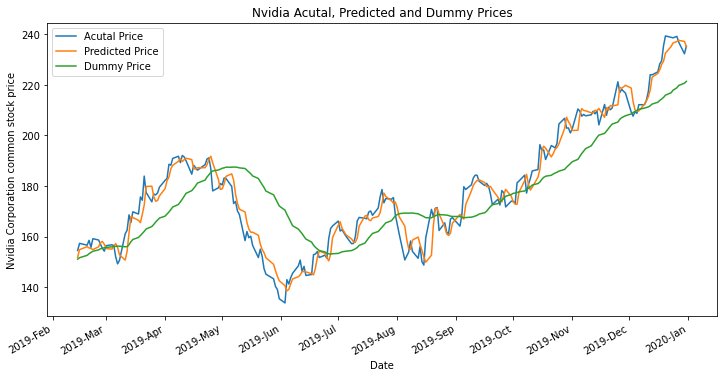

In [20]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str)

plotter.single_plot()

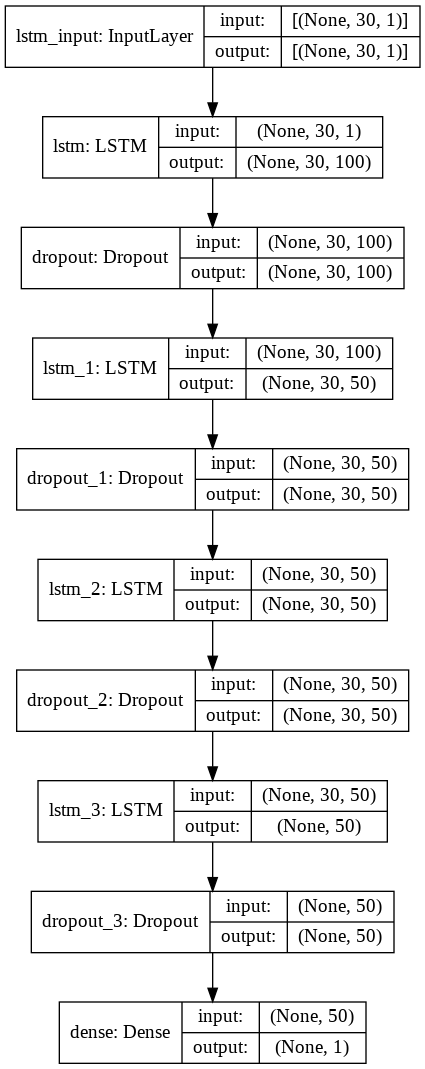

In [21]:
plot_model(model, show_shapes=True, expand_nested=True)

In [22]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)

MSE:  0.0027287040234300675
RMSE:  0.0522369986066396
MAE:  0.040663685063055025


In [23]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE:'+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n')
error_file.close()

Mounted at /content/gdrive/


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/LSTM_Nvidia/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/LSTM_Nvidia/assets
